<a href="https://colab.research.google.com/github/TomisinT99/boston-housing-analysis/blob/main/Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
df=pd.read_csv("BostonHousing.csv")

df.head(11)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.10,18.9


In [7]:
!pip install pyspark




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=56e41f2b7fa961e025801379ad2f837ec5298016d86b75e46429a48aad084212
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


5

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, count
import matplotlib.pyplot as plt
import pandas as pd


In [9]:
spark = SparkSession.builder.appName("BostonHousing.csv").getOrCreate()


In [10]:
from google.colab import files
uploaded = files.upload()

file_path = list(uploaded.keys())[0]


Saving BostonHousing.csv to BostonHousing (1).csv


In [11]:
Boston_housing = spark.read.csv(file_path, header=True, inferSchema=True)

Boston_housing.show(5)


+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [12]:

Boston_housing = Boston_housing.dropna()

Boston_housing = Boston_housing.withColumn("RM", col("RM").cast("double"))
Boston_housing = Boston_housing.withColumn("MEDV", col("MEDV").cast("double"))

Boston_housing.printSchema()


root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- MEDV: double (nullable = true)



In [13]:
bin_edges = [0, 4, 5, 6, 7, 8, 9, 10]

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def get_bin(rm):
    for i in range(len(bin_edges)-1):
        if bin_edges[i] <= rm < bin_edges[i+1]:
            return i
    return len(bin_edges) - 1

bin_udf = udf(get_bin, IntegerType())
Boston_housing = Boston_housing.withColumn("RM_bin", bin_udf(col("RM")))

Boston_housing.show(5)


+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+------+
|   crim|  zn|indus|chas|  nox|   RM| age|   dis|rad|tax|ptratio|     b|lstat|MEDV|RM_bin|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+------+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|     3|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|     3|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|     4|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|     3|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|     4|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+------+
only showing top 5 rows



In [14]:
stats = Boston_housing.groupBy("RM_bin").agg(
    mean("MEDV").alias("mean_MEDV"),
    stddev("MEDV").alias("stddev_MEDV"),
    count("MEDV").alias("count_MEDV")
)

stats.show()


+------+------------------+------------------+----------+
|RM_bin|         mean_MEDV|       stddev_MEDV|count_MEDV|
+------+------------------+------------------+----------+
|     1|16.023076923076925|10.943959813991297|        13|
|     3| 22.01598513011151| 6.467721594707344|       269|
|     5|              44.2| 8.092383250110357|        13|
|     4|36.917647058823526| 8.316362326939656|        51|
|     2|17.487341772151893| 5.352667460226968|       158|
|     0|              25.3|3.1112698372208083|         2|
+------+------------------+------------------+----------+



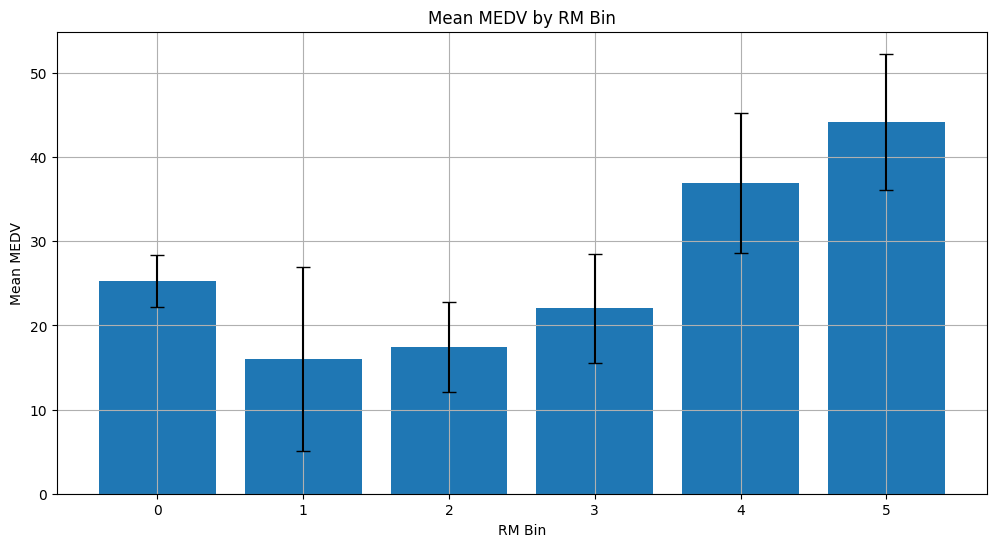

In [15]:
# Convert to Pandas DataFrame
stats_pd = stats.toPandas()

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(stats_pd['RM_bin'], stats_pd['mean_MEDV'], yerr=stats_pd['stddev_MEDV'], capsize=5)
plt.xlabel('RM Bin')
plt.ylabel('Mean MEDV')
plt.title('Mean MEDV by RM Bin')
plt.xticks(stats_pd['RM_bin'])
plt.grid(True)
plt.show()
